### Annotated model fitting with emcee 

In [21]:
from typing import Tuple
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import emcee
import scipy.optimize as op

Define a double gaussian function (mean, spread, amplitude)

In [22]:
def double_gaussian(x: npt.NDArray[np.float64], params: Tuple) -> npt.NDArray[np.float64]:
    mu1, sigma1, amp1, mu2, sigma2, amp2 = params
    g1 = amp1 * np.exp(-0.5 * ((x - mu1) / sigma1)**2)
    g2 = amp2 * np.exp(-0.5 * ((x - mu2) / sigma2)**2)
    return g1 + g2

Create a data vector which we want to fit.  In this example I create the data from the true value and add some noise to each point

In [3]:
true_params = [0, 0.5, 1, 2, 0.5, 0.8]
x = np.linspace(-2, 4, 500)
y_true = double_gaussian(x, true_params)

# Assuming all of our errors are just a simple standard deviation of sigma = 0.2:
sigma = 0.2
y_obs = y_true + np.random.normal(0, sigma, len(x))



Now, construct your log likelihood.  We are going to assume our likelihood is a **gaussian** because it is the simplest case, but there's also a solid mathematical reason for why it's a good model for the likelihood.
> Central Limit Theorem: the distribution of the sum (or average) of a large number of independent, identically distributed variables will be approximately normal, regardless of the underlying distribution. This implies that many natural processes, which can be thought of as the sum of many small effects, will have a Gaussian distribution.

The Likelihood tells us the probability of getting our data given our model.  For a single data point:
$$
\mathrm{Likelihood}(\mathrm{Data}|\mathrm{Model}) = \mathrm{Probability}(\mathrm{Data}|\mathrm{Model}) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left[ -\frac{\left(\mathrm{Data}-\mathrm{Model}\right)^2}{2\sigma^2} \right]
$$

Recall probabilities multiply, so P(A and B) = P(A)*P(B). Thus the probability of fitting many points is the above multiplied N times for each data point i:

$$
L(d|M) = \frac{1}{\sqrt{2\pi\sigma_1^2}} \exp \left[ -\frac{\left(d_1-M\right)^2}{2\sigma_1^2} \right] \times \frac{1}{\sqrt{2\pi\sigma_2^2}} \exp \left[ -\frac{\left(d_2-M\right)^2}{2\sigma_2^2} \right] \times \frac{1}{\sqrt{2\pi\sigma_3^2}} \exp \left[ -\frac{\left(d_3-M\right)^2}{2\sigma_3^2} \right] \dots
$$

Or, assuming the errors are not specific to a single data point:

$$
L(d|M) = \frac{1}{(2\pi\sigma^2)^{N/2}} \exp \left[ -\frac{\sum_i^N\left(d_i-M\right)^2}{2\sigma^2} \right] 
$$

Now, logs are nice because they turn multiplication into addition:

$$\ln(AB) = \ln(A) + \ln(B)$$

Let's use this on the Likelihood to get the LOG LIKELIHOOD that emcee wants:
$$
\ln L(d|M) = \ln \left(\frac{1}{(2\pi\sigma^2)^{N/2}} \right) +  \left[ -\frac{\sum_i^N\left(d_i-M\right)^2}{2\sigma^2} \right] 
$$

Dropping the constant additive term (won't affect relative probabilities between model parameters)
$$
\ln L(d|M) = -\sum_i^N\frac{\left(d_i-M\right)^2}{2\sigma^2} 
$$


In [4]:
def ln_likelihood(
        params: Tuple, 
        x: npt.NDArray[np.float64], 
        data: npt.NDArray[np.float64], 
        error: float
) -> float:
    model = double_gaussian(x, params)
    inv_sigma2 = 1.0 / (error**2)
    return -0.5*(np.sum((data - model)**2 * inv_sigma2))

Define valid ranges for our parameters.  This is the format emcee expects

In [5]:
def ln_prior(params: Tuple) -> float:
    mu1, sigma1, amp1, mu2, sigma2, amp2 = params
    if -5 < mu1 < 5 and 0 < sigma1 < 2 and 0 < amp1 < 2 and -5 < mu2 < 5 and 0 < sigma2 < 2 and 0 < amp2 < 2:
        return 0.0
    else:
        return -np.inf


Now use Bayes' Theorem to define a posterior to actually sample.

In [6]:
def log_probability(
        params: Tuple, 
        x: npt.NDArray[np.float64], 
        y: npt.NDArray[np.float64], 
        err: float
) -> float:
    lp = ln_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, x, y, err)


Use scipy optimize for a quick first guess to start our MCMC chain:

In [7]:
nll = lambda *args: -ln_likelihood(*args)
result = op.minimize(nll, true_params, args=(x, y_obs, sigma))

Define MCMC Parameters and instantiate the sampler

In [20]:
pos = result["x"] + 1e-4 * np.random.randn(32, 6)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y_obs, sigma))
_ = sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 50000/50000 [01:48<00:00, 461.80it/s]


Run the mcmc chain

The fitting is done.  Now we want to only extract valuable information from the chain.  See emcee documentation for more details:

In [23]:
tau = sampler.get_autocorr_time()
print(tau)

[71.26032232 68.19014438 69.081755   69.54368945 69.73632607 71.35062017]


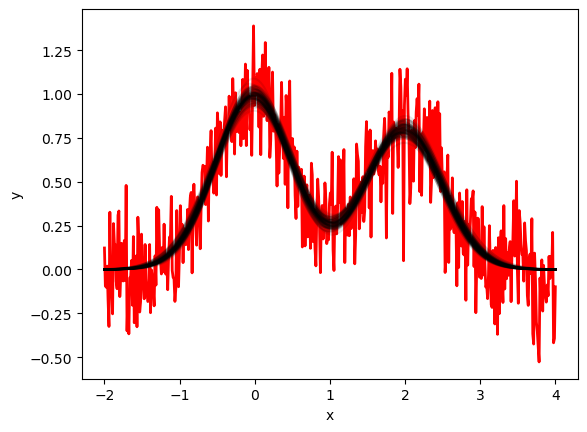

In [24]:
flat_samples = sampler.get_chain(discard=140, thin=15, flat=True)
plt.figure()
plt.plot(x, y_obs, color="r", lw=2)
for params in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    plt.plot(x, double_gaussian(x, params), color="k", alpha=0.1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


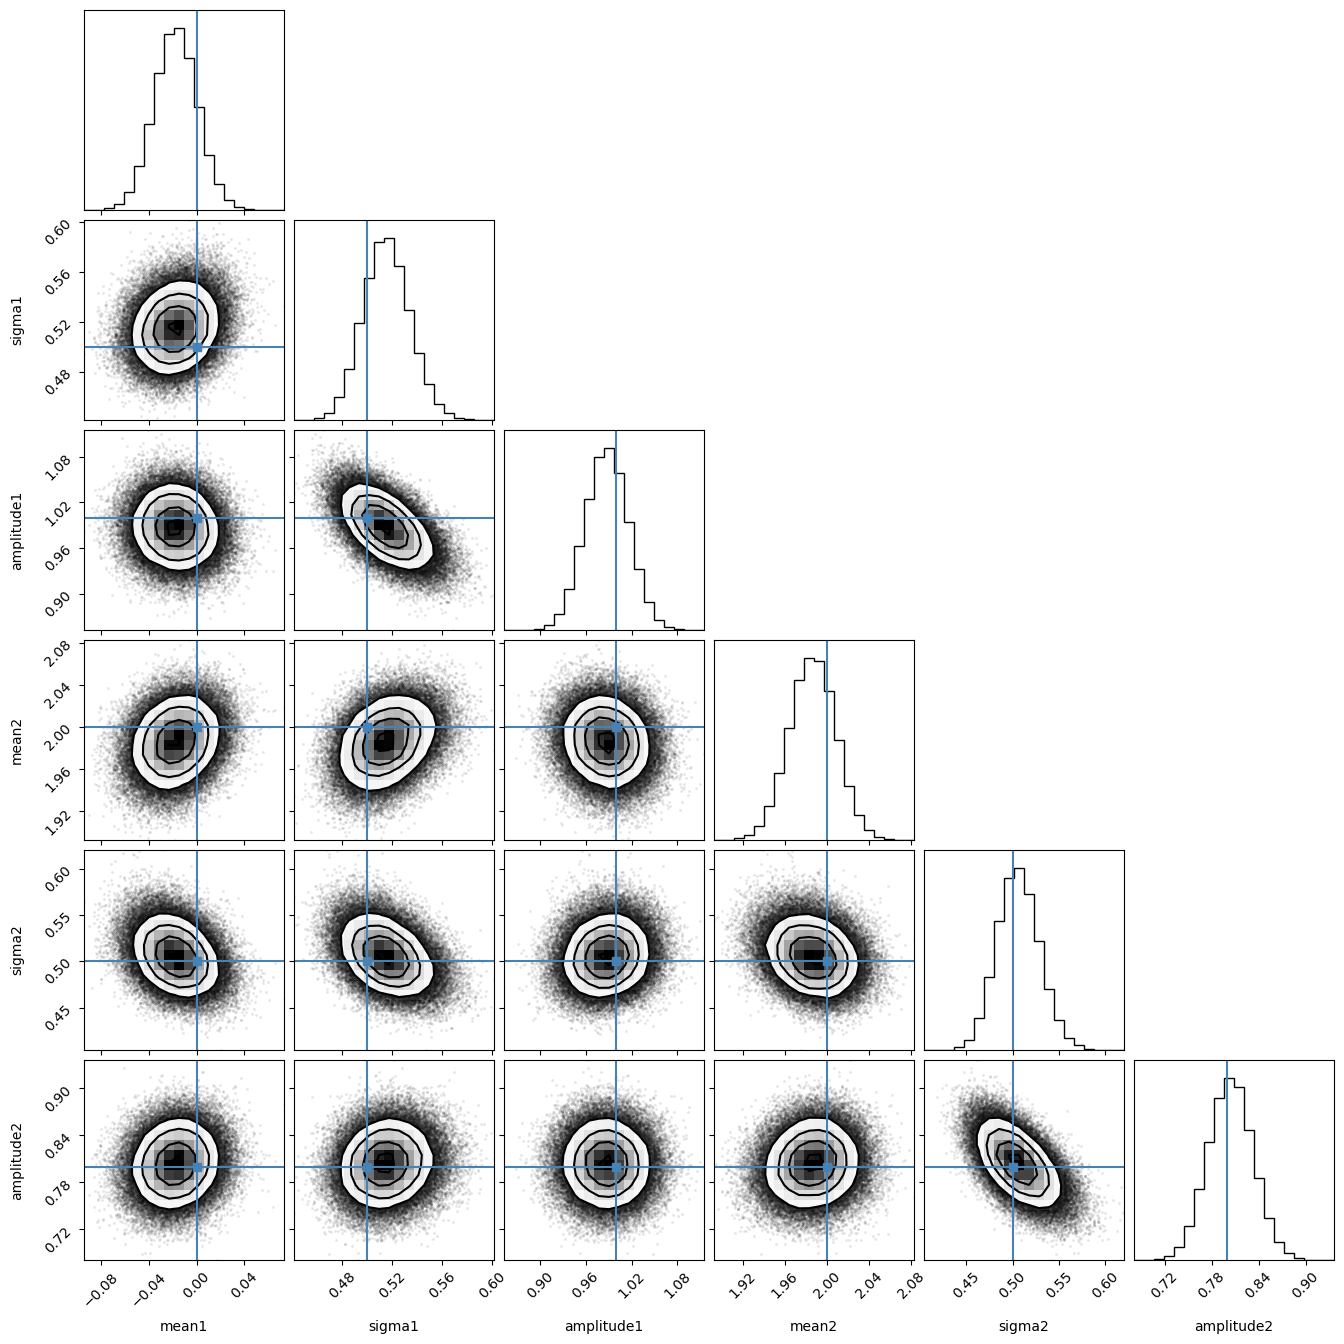

In [25]:
import corner
labels=["mean1", "sigma1", "amplitude1", "mean2", "sigma2", "amplitude2"]
fig = corner.corner(flat_samples, labels=labels, truths=true_params)
